# A Finite Element Examples: Beam 02

<font color='red'>The error is that you are using the Beam element. Only the Frame2D does stability/$P-\Delta$</span>

This example is based on the beam02 example distributed with FEM.edu

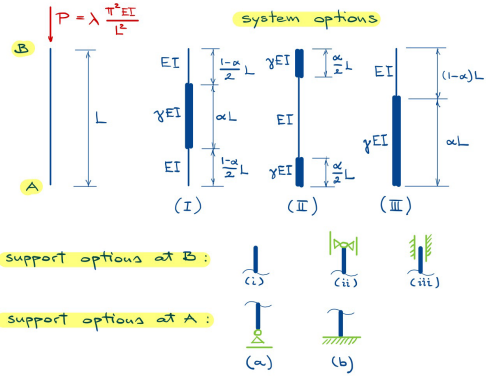

## Load needed components

We need to add the local code to the path or python won't find FEM.edu

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join("..")))

Now load the needed components of FEM.edu

In [2]:
from femedu.domain import *
from femedu.solver.NewtonRaphsonSolver import *
#from femedu.elements.Beam2D import *
from femedu.elements.Frame2D import *
from femedu.materials.ElasticSection import ElasticSection

## Build a model

In [3]:
# initialize a system model

alpha = 0.5
gamma = 2.
L = 100.


# System Options (1 = stiffened center, 2 = stiffened ends, 3 = stiffened bottom
sysop = [1,2,3]

#SpanLengths = [[(1-alpha)*L/2,    alpha*L,     (1-alpha)*L/2],
#               [alpha*L/2,      (1-alpha)*L,     alpha*L/2],
#               [alpha*L,        (1-alpha)*L,         0    ]    ]

SpanLengths = [ (1-alpha)*L/2, alpha*L, (1-alpha)*L/2 ]
Nelems = 2     # number of elements
#params = {'E': 29000., 'A': 5, 'I': 50}

params = [{'E': 29000., 'A': 5, 'I': gamma*100.}, 
          {'E': 29000., 'A': 5, 'I': 100.}, 
          {'E': 29000., 'A': 5, 'I': gamma*100.}]

# ========== setting load parameters ==============

w = -0.01                     # uniform lateral load on the column        
#Pcr = np.pi**2 * params['E'] * params['I'] / L**2    # Euler buckling load
Pcr = np.pi**2 * 29000. * 100. / L**2

# ========== setting analysis parameters ==============

target_load_level = 1.95      # 195% of Euler load
max_steps = 10                # solve max_steps points on the primary path


w   *= 0.01
#Pcr *= 0.01  # PETER SAYS: this line is reducing your load to 1/100th of Pcr

#target_load_level = 99.      # 99% of Euler load

# define a list of target load levels
load_levels = np.linspace(0, target_load_level, max_steps)


# meshing parameters
Xnode  = 0.0
Ynode  = 0.0
# Offset = 0.0   # PETER SAYS: not needed

model = System()
model.setSolver(NewtonRaphsonSolver())

# create left node
nd0 = Node(Xnode, Ynode)
nd0.fixDOF('ux', 'uy')     # pin support left end
model += nd0

# initialization for node and element creation
ndi = nd0

for SpanLength, param in zip(SpanLengths, params):

    Le = SpanLength / Nelems

    for e in range(Nelems):
                
        # create next node
        Xnode += Le
        ndj = Node(Xnode, Ynode)
        model += ndj  
    
        # create elements
        elem = Frame2D(ndi, ndj, ElasticSection(param))
        model += elem   
            
       # shift one node to the right
        ndi = ndj
        
        elem.setDistLoad(w)  # needs to go inside the loop: see indentation
    
    # define support(s)
    #ndj.fixDOF('uy')           # roller support right end

    # move on to the next span
    #Offset = Xnode   # PETER SAYS: not needed

# define support(s)    
ndi.fixDOF('uy')

# done building the model

# ==== complete the reference load ====

# these are only nodal forces as part of the reference load
# .. load only the last node

ndi.setLoad((-Pcr,), ('ux',))


## Solve the system equations

In [4]:
# analyze the model
#model.solve()
#model.solve(verbose=True)

#model.report()

In [5]:
## Stability Analysis

In [6]:
# initialize the analysis:
model.resetDisplacements()   # set U to all zeros
model.setLoadFactor(0.0)     # define a known equilibrium solution

model.startRecorder()        # not doing anything yet, but will do the data collection soon

detKt   = []
lambdas = []

# solve for all load_levels
for loadfactor in load_levels:

    # define node X2 as the controled node; downward direction is prescribed:
    model.setLoadFactor(loadfactor)
    model.solve(verbose=True)

    # stability check
    lambdas.append(model.loadfactor)
    dKt = model.solver.checkStability()
    detKt.append(dKt)
    
    # setting a stop once we get past the critical load
    if dKt < 0.0:
        break

    # report results
    print('+')
    #model.report()   # PETER SAYS: turning this off

    print("\n=== next load level ===\n")


norm of the out-of-balance force:   0.0000e+00
+

 ** Stability check: (smallest eigenvalue of Kt) = 68.49169936366013

+

=== next load level ===

norm of the out-of-balance force:   6.2014e+02
norm of the out-of-balance force:   3.9021e-04
norm of the out-of-balance force:   6.8958e-13
+

 ** Stability check: (smallest eigenvalue of Kt) = 54.97166704377639

+

=== next load level ===

norm of the out-of-balance force:   6.2014e+02
norm of the out-of-balance force:   9.7819e-04
norm of the out-of-balance force:   2.0340e-12
+

 ** Stability check: (smallest eigenvalue of Kt) = 41.439841601461325

+

=== next load level ===

norm of the out-of-balance force:   6.2014e+02
norm of the out-of-balance force:   1.9582e-03
norm of the out-of-balance force:   1.7699e-12
+

 ** Stability check: (smallest eigenvalue of Kt) = 27.89581835997508

+

=== next load level ===

norm of the out-of-balance force:   6.2014e+02
norm of the out-of-balance force:   3.9024e-03
norm of the out-of-balance forc

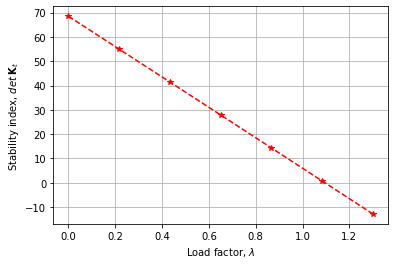

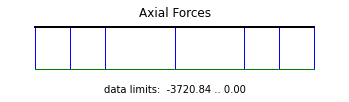

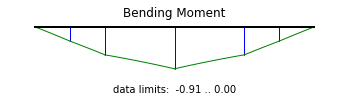

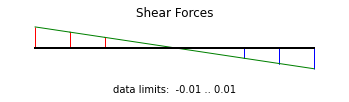

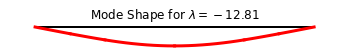

In [7]:
#
# ==== create some nice plots ===
#

plt.plot(lambdas,detKt,'--*r')
plt.grid(True)
plt.xlabel('Load factor, $ \lambda $')
plt.ylabel("Stability index, $ {det}\: {\\bf K}_t $")
plt.show()

model.plot(factor=1000.0, filename="beam2_deformed.png")

model.beamValuePlot("F", filename="beam2_force.png")
model.beamValuePlot("M", filename="beam2_moment.png")
model.beamValuePlot("V", filename="beam2_shear.png")

model.plotBucklingMode(factor=10., filename="beam2_buckling_mode0.png")
